In [70]:
### Importo librearias
import pandas as pd
import numpy as np
#from inline_sql import sql
import matplotlib.pyplot as plt
from matplotlib import ticker, rcParams
import seaborn as sns

### cargo los datos crudos
  
# cargo los dataframes de TWB

pbi_paises = pd.read_csv('./TablasOriginales/API_NY.GDP.PCAP.CD_DS2_en_csv_v2_73.csv',skiprows=4)

datos_paises = pd.read_csv('./TablasOriginales/Metadata_Country_API_NY.GDP.PCAP.CD_DS2_en_csv_v2_73.csv')

metadata = pd.read_csv('./TablasOriginales/Metadata_Indicator_API_NY.GDP.PCAP.CD_DS2_en_csv_v2_73.csv')

# cargo Dataframes del Ministerio

secciones_original = pd.read_csv('./TablasOriginales/lista-secciones.csv')

sedes_original = pd.read_csv('./TablasOriginales/lista-sedes.csv')

datos_sedes = pd.read_csv('./TablasOriginales/lista-sedes-datos.csv')
    
### Creo los esquemas necesarios para el proyecto 

# creo los esquemas en dataframe vacios

redes_sociales = pd.DataFrame(columns=['id_sede','url'])

sedes = pd.DataFrame(columns=['id_sede','nom_sede','codigo_pais'])

secciones  = pd.DataFrame(columns=['id_sede','nom_seccion'])

paises  = pd.DataFrame(columns=['codigo_pais','nom_pais','id_region','pbi'])

regiones = pd.DataFrame(columns=['id_region','nom_region'])



### importo los datos a los dataframe vacios

# Regiones
# importo:
#   nom_region del dataframe datos_paises
regiones['nom_region'] = datos_sedes['region_geografica'].sort_values().unique() # selecciones los valores, ordeno y luego dejo solo los valores unicos
#   genero un id_regino para cada region
regiones['id_region'] = np.array(range(1,len(regiones['nom_region'])+1))# el array es  [1,2,3,4,5,6,7,8,9]  

# Paises
# importo:
#   codigo_pais, nom_pais, id_region del dataframe datos_paises
paises[['codigo_pais','nom_pais','id_region']] = datos_sedes[['pais_iso_3','pais_castellano','region_geografica']]
#   estandarizo GRB a GBR 
paises["codigo_pais"] = paises["codigo_pais"].replace(['GRB'],'GBR')
#   pib del dataframe pib_paises
paises['pbi'] = pd.merge(paises['codigo_pais'], pbi_paises[['Country Code','2022']],
                         left_on='codigo_pais', right_on='Country Code',how='left')['2022']# Hago un natural join con codigo_pais del dataframe paises
                                                                                # y Country Code de pbi_paises para accedes a el pbi en 2022,
                                                                                # esos valores los importo a la columna pbi
# Sedes
# importo:
#   id_sede,nom_sede,codigo_territorio del dataframe datos_sedes
sedes[['id_sede','nom_sede','codigo_pais']] = datos_sedes[['sede_id','sede_desc_castellano','pais_iso_3']]

# Secciones
# importo:
#   id_sede, nom_seccion del dataframe secciones_original
secciones[['id_sede','nom_seccion']] = secciones_original[['sede_id','sede_desc_castellano']]

# Redes Sociales
#   importo id_sede, url del dataframe datos_sedes
redes_sociales[['id_sede','url']] = datos_sedes[['sede_id','redes_sociales']]



### Limpieza y estandarizacion

# Paises
#   elimino los duplicados
paises.drop_duplicates(inplace=True)
#   elimino las regiones de mi dataframe paises
paises.dropna(inplace=True)
#paises[paises['id_region'].notnull()]
#   cambio las regiones por su id
paises['id_region'] = paises['id_region'].apply(lambda x: regiones[regiones.loc[:,'nom_region'] == x]['id_region'].values[0])
#   reseto sus indices
paises.reset_index(inplace=True,drop=True)

# Sedes
#   estandarizo GRB a GBR
sedes["codigo_pais"] = sedes["codigo_pais"].replace(['GRB'],'GBR')

# Redes Sociales:   
#   Crep un dataframe con los datos sin precesar
redes_sociales_s_procesar = redes_sociales.copy()
#   Vacion el dataframe   
redes_sociales = pd.DataFrame(columns=['id_sede','url'])

#   Elimino las sedes que no tienen redes sociales
redes_sociales_s_procesar.dropna(inplace=True)
#   Reseteo el indice
redes_sociales_s_procesar.reset_index(inplace=True,drop=True)
#   Vuelvo los valores de la columna url en atomicos
for i in range(redes_sociales_s_procesar.shape[0]):
    # accedo al valor de la columna redes_sociales por la posicion en i
    urls =  redes_sociales_s_procesar.loc[i,'url']   
    # creo una lista con las urls eliminando el ultimo elemento
    lista_urls = urls.split('  //  ')
    # si la lista tiene mas de un elemento significa que elutlimo elemento es un espacio, por lo cual lo quito
    # creo una lista de igual longitud que lista_urls con todos sus valores igual a la sede que pertenece las urls
    lista_full_sede_id = np.full(len(lista_urls), redes_sociales_s_procesar.loc[i,'id_sede'])
    # creo una lista de tuplas (sede_id, urls)
    lista_tuplas_urls = zip(lista_full_sede_id,lista_urls)
    # genero un dataframe con las tuplas de lista_tuplas_urls
    df_url_sede = pd.DataFrame(lista_tuplas_urls,columns=['id_sede','url'])
    # concateno las las nuevas urls al dataframe de redes sociales
    redes_sociales = pd.concat([redes_sociales,df_url_sede], axis=0,ignore_index=True)          
#   reseteo el indice de redes_sociales
redes_sociales.reset_index(inplace=True,drop=True)

# Secciones
#   Elimino duplicados
secciones.drop_duplicates(inplace=True)



### Expoerto los dataframes
lista_esquemas = [regiones,paises,sedes,secciones,redes_sociales]
nombre_cvs  = ['regiones.csv','paises.csv','sedes.csv','secciones.csv','redes_sociales.csv']
for esquema,nombre in zip(lista_esquemas,nombre_cvs):
    esquema.to_csv('./TablasLimpias/'+nombre,index=False, encoding = 'utf-8')


In [37]:
regiones

,id_region,nom_region
0,1,AMÉRICA CENTRAL Y CARIBE
1,2,AMÉRICA DEL NORTE
2,3,AMÉRICA DEL SUR
3,4,ASIA
4,5,EUROPA CENTRAL Y ORIENTAL
5,6,EUROPA OCCIDENTAL
6,7,OCEANÍA
7,8,ÁFRICA DEL NORTE Y CERCANO ORIENTE
8,9,ÁFRICA SUBSAHARIANA


In [111]:
paises

,codigo_pais,nom_pais,id_region,pbi
0,BRA,REPÚBLICA FEDERATIVA DEL BRASIL,3,8917.674911
1,CHL,REPÚBLICA DE CHILE,3,15355.479740
2,PRY,REPÚBLICA DEL PARAGUAY,3,6153.055657
3,USA,Estados Unidos de América,2,76329.582265
4,ESP,REINO DE ESPAÑA,6,29674.544286
...,...,...,...,...
82,TUN,REPÚBLICA TUNECINA,8,3747.419391
83,UKR,UCRANIA,5,4533.975586
84,HUN,HUNGRÍA,5,18390.184999
85,VNM,REPÚBLICA SOCIALISTA DE VIETNAM,4,4163.514299


In [82]:
paises_regiones = pd.merge(paises,regiones)[['nom_region','pbi']]

In [112]:
paises[paises['id_region'] == 2]

,codigo_pais,nom_pais,id_region,pbi
3,USA,Estados Unidos de América,2,76329.582265
13,CAN,CANADÁ,2,54917.662523
17,MEX,ESTADOS UNIDOS MEXICANOS,2,11496.522872


In [95]:
paises[paises['id_region'] == 7]. describe()

,id_region,pbi
count,2.0,2.000000
mean,7.0,56759.218788
std,0.0,11795.427998
min,7.0,48418.591663
25%,7.0,52588.905225
50%,7.0,56759.218788
75%,7.0,60929.532350
max,7.0,65099.845912


In [114]:
paises_regiones.groupby('nom_region').median().sort_values('pbi')

,pbi
nom_region,
ÁFRICA SUBSAHARIANA,2099.301938
ÁFRICA DEL NORTE Y CERCANO ORIENTE,4295.407496
AMÉRICA DEL SUR,6874.997662
ASIA,7762.073829
AMÉRICA CENTRAL Y CARIBE,11571.087096
EUROPA CENTRAL Y ORIENTAL,15528.753898
EUROPA OCCIDENTAL,49926.825430
AMÉRICA DEL NORTE,54917.662523
OCEANÍA,56759.218788


In [104]:
paises.groupby('id_region').mean().sort_values('pbi')

C:\Users\Carlos\AppData\Local\Temp\ipykernel_13172\235094424.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  paises.groupby('id_region').mean().sort_values('pbi')


,pbi
id_region,
9,2459.067444
8,4508.710459
3,9447.208139
1,13722.881428
5,15425.606272
4,23375.334828
2,47581.255886
6,52574.973126
7,56759.218788


In [182]:
regiones['nom_region'].values

array(['AMÉRICA  CENTRAL  Y  CARIBE', 'AMÉRICA  DEL  NORTE',
       'AMÉRICA  DEL  SUR', 'ASIA', 'EUROPA  CENTRAL  Y  ORIENTAL',
       'EUROPA  OCCIDENTAL', 'OCEANÍA',
       'ÁFRICA  DEL  NORTE  Y  CERCANO  ORIENTE', 'ÁFRICA  SUBSAHARIANA'],
      dtype=object)

C:\Users\Carlos\AppData\Local\Temp\ipykernel_13172\3875811102.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(),fontsize = 15)   # aumento tamño etiquetas del eje y


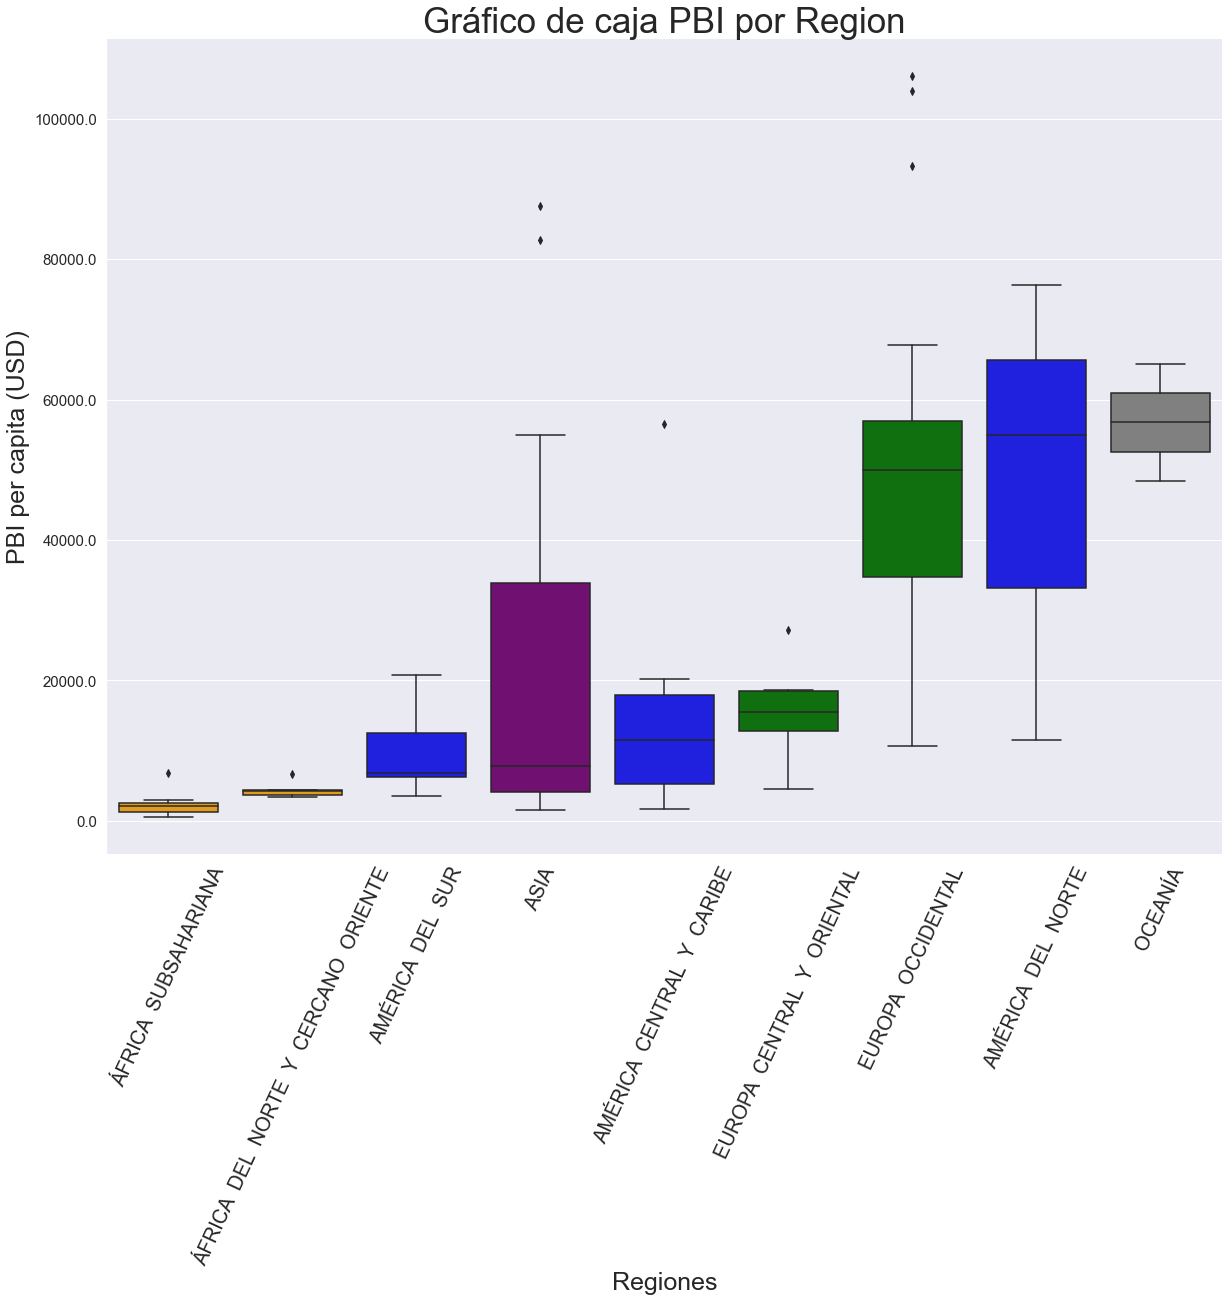

In [204]:
#creo un dataframe con las regiones y sus pbi
paises_regiones = pd.merge(paises,regiones)[['nom_region','pbi']]

fig,ax = plt.subplots(figsize=(20,15))

rcParams['font.family'] = 'sans-serif'           # Modifica el tipo de letra
rcParams['axes.spines.right']  = False            # Elimina linea derecha   del recuadro
rcParams['axes.spines.left']   = True             # Agrega  linea izquierda del recuadro
rcParams['axes.spines.top']    = False            # Elimina linea superior  del recuadro
rcParams['axes.spines.bottom'] = False             # Elimina linea inferior  del recuadro

#creo un array para ordenar por mediana por region de forma ascendente
indice_ord = paises_regiones.groupby('nom_region').median().sort_values('pbi').index

ax = sns.boxplot(x='nom_region',
            y='pbi',
            data= paises_regiones,
            order=indice_ord,
            palette=['orange','orange','blue','purple','blue','green','green','blue','gray']
            )

plt.title('Gráfico de caja PBI por Region') 
ax.set_xticklabels(indice_ord,fontsize = 20)        # aumento tamño etiquetas del eje x
ax.set_xlabel('Regiones',fontsize=25)               # Coloco titulo con tamaño 25 al eje x
plt.xticks(rotation=65)                             # Roto las etiqueta del eje x

ax.set_yticklabels(ax.get_yticks(),fontsize = 15)   # aumento tamño etiquetas del eje y
ax.set_ylabel('PBI per capita (USD)',fontsize=25)   # Coloco titulo con tamaño 25 al eje y


plt.show()